# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import random
from AirControl.communicator import Communicator
from AirControl import schemaDef
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
connection = Communicator()
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
output = schemaDef.get_output()
connection.send_data(output)
output =  connection.receive_data()


In [3]:
output

{'AGL': 4.23942232,
 'MSL': -41.5314941,
 'CurrentRPM': 0.0,
 'MaxRPM': 2500.0,
 'MaxPower': 5000.0,
 'CurrentPower': 0.0,
 'CurrentFuel': 0.0,
 'CurrentSpeed': 0.0,
 'BankAngle': -2.93484618e-07,
 'IfCollision': 'false',
 'currentLocation_x': 18.5009251,
 'currentLocation_y': -12.6587992,
 'currentLocation_z': -62.1478271,
 'PitchAngle': 1.66752621e-08,
 'ScreenCapture': '',
 'LidarPointCloud': [100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  

In [2]:
control_schema = schemaDef.set_control(Pitch=0.0, Roll=0.0, Yaw=0.0,Throttle=0.0, StickyThrottle=0.5, Brake=0, Flaps=0,IsOutput=True)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (8,)
Number of actions:  4


Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

In [3]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: -225.00
Episode 200	Average Score: -176.93
Episode 300	Average Score: -87.32
Episode 400	Average Score: -56.19
Episode 500	Average Score: -66.67
Episode 600	Average Score: -42.52
Episode 700	Average Score: 36.50
Episode 800	Average Score: 48.18
Episode 900	Average Score: 155.64
Episode 1000	Average Score: 191.26
Episode 1100	Average Score: 185.16
Episode 1200	Average Score: 180.23
Episode 1300	Average Score: 184.97
Episode 1400	Average Score: 188.67
Episode 1500	Average Score: 181.42
Episode 1600	Average Score: 199.10
Episode 1604	Average Score: 200.17
Environment solved in 1504 episodes!	Average Score: 200.17


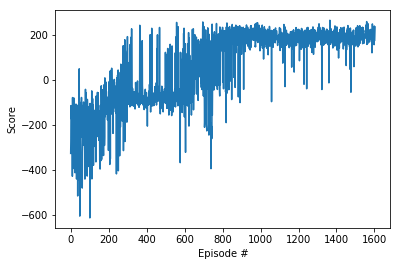

In [3]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [4]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  